<img width="10%" alt="Naas" src="https://landen.imgix.net/jtci2pxwjczr/assets/5ice39g4.png?w=160"/>

# OpenPIV - OpenPIV-Python examples that you can execute in your browser

<a href="https://app.naas.ai/user-redirect/naas/downloader?url=https://raw.githubusercontent.com/jupyter-naas/awesome-notebooks/master/openpiv/openpiv-python-template.ipynb" target="_parent"><img src="https://naasai-public.s3.eu-west-3.amazonaws.com/open_in_naas.svg"/></a><br><br><a href="https://github.com/jupyter-naas/awesome-notebooks/issues/new?assignees=&labels=&template=template-request.md&title=Tool+-+Action+of+the+notebook+">Template request</a> | <a href="https://github.com/jupyter-naas/awesome-notebooks/issues/new?assignees=&labels=bug&template=bug_report.md&title=OpenPIV+-+OpenPIV:+Error+short+description">Bug report</a>

**Tags:** #piv #openpiv #fluidmechanics #openpiv-python

**Author:** [Alex Liberzon](https://www.linkedin.com/in/alexliberzon/)

Install OpenPIV and run over two images included in the repo or on animated GIF images from the web.

## Input

In [3]:
%%pip install git+https://github.com/openpiv/openpiv-python
%pip install ipywidgets

  Cloning https://github.com/openpiv/openpiv-python to /tmp/pip-req-build-4l3n3sqx
  Running command git clone --filter=blob:none --quiet https://github.com/openpiv/openpiv-python /tmp/pip-req-build-4l3n3sqx
  Resolved https://github.com/openpiv/openpiv-python to commit baae66d8bee6ef5a9d4ce77aad1153df063ef3d3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.4/134.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.1/384.1 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.4 MB/s eta 0:00:00:00:01

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python -m pip install --upgrade pip


## Import what is necessary from OpenPIV

In [4]:
from openpiv import tools, validation, filters, scaling, pyprocess
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from ipywidgets import interact_manual, interactive, fixed, IntSlider, HBox, VBox, Layout

## Read a pair of PIV images

In [5]:
frame_a  = tools.imread( './img/exp1_001_b.bmp' )
frame_b  = tools.imread( './img/exp1_001_c.bmp' )

## Show them using matplotlib

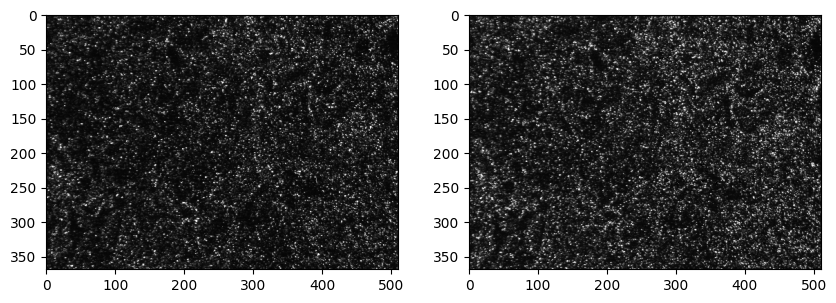

In [6]:
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)


## Define the PIV analysis parameters

1. Size of the interrogation window in frame A (winsize), 
2. Size of the search window in frame B (searchsize is larger or equal to winsize), 
3. overlap between the neighbouring windows (overlap), 
4. time interval of the PIV recording ($\Delta t$)
5. type of the peak quality (signal-to-noise ratio)

In [7]:
winsize = 32 # pixels, interrogation window size in frame A
searchsize = 40  # pixels, search in image B
overlap = 12 # pixels, 50% overlap
dt = 0.02 # sec, time interval between pulses


## Run the OpenPIV (fast code, precompiled in Cython)

In [8]:
u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=winsize, 
                                                       overlap=overlap, 
                                                       dt=dt, 
                                                       search_area_size=searchsize, 
                                                       sig2noise_method='peak2peak')

## Get a list of coordinates for the vector field

In [9]:
x, y = pyprocess.get_coordinates( image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )

## Clean the peaks that are below a quality threshold

In [10]:
u1, v1, flags = validation.sig2noise_val( u0, v0, 
                                        sig2noise, 
                                        threshold = 1.05 )
# if you need more detailed look, first create a histogram of sig2noise
# plt.hist(sig2noise.flatten())
# to see where is a reasonable limit

## Replace those that are masked as bad vectors with local interpolation

In [11]:
# filter out outliers that are very different from the
# neighbours

u2, v2 = filters.replace_outliers( u1, v1, 
                                  method='localmean', 
                                  max_iter=3, 
                                  kernel_size=3)

## Scale the results from pix/dt to mm/sec

In [12]:
# convert x,y to mm
# convert u,v to mm/sec

x, y, u3, v3 = scaling.uniform(x, y, u2, v2, 
                               scaling_factor = 96.52 ) # 96.52 microns/pixel

# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x, y, u3, v3 = tools.transform_coordinates(x, y, u3, v3)

In [13]:
# mask the results on place of flags
u3 = np.where(flags, 0, u3)
v3 = np.where(flags, 0, v3)

## store the result in a text file

In [14]:
# save in the simple ASCII table format
tools.save(x, y, u3, v3, flags, 'exp1_001.txt' )

## plot the data stored in the text file

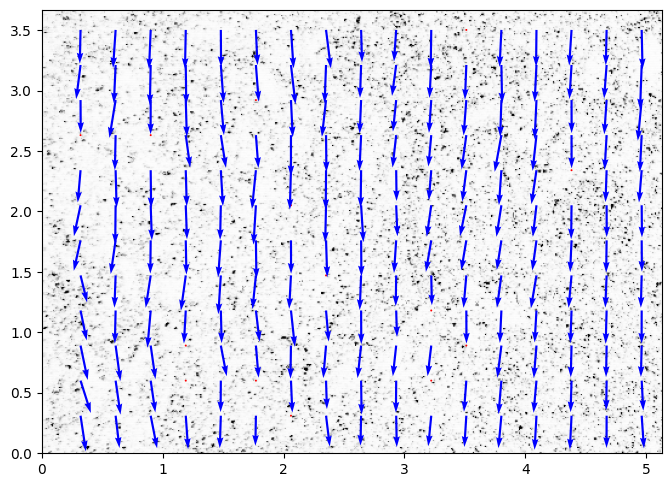

In [15]:
fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field('exp1_001.txt', 
                           ax=ax, scaling_factor=96.52, 
                           scale=50, # scale defines here the arrow length
                           width=0.0035, # width is the thickness of the arrow
                           on_img=True, # overlay on the image
                           image_name='./img/exp1_001_b.bmp');

# Another example
## Use any pair of images that you can access via URL
For instance we can use images from PIV Challenge http://www.pivchallenge.org/

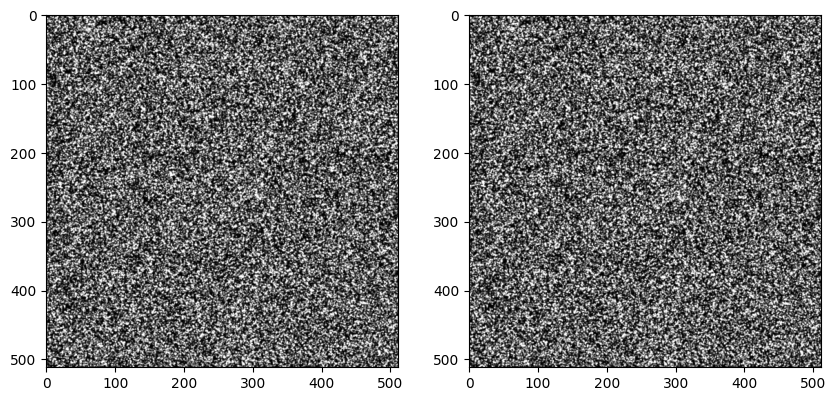

In [16]:
frame_a = tools.imread('http://www.pivchallenge.org/pub/B/B001_1.tif')
frame_b = tools.imread('http://www.pivchallenge.org/pub/B/B001_2.tif')
fig,ax = plt.subplots(1,2,figsize=(10,8))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

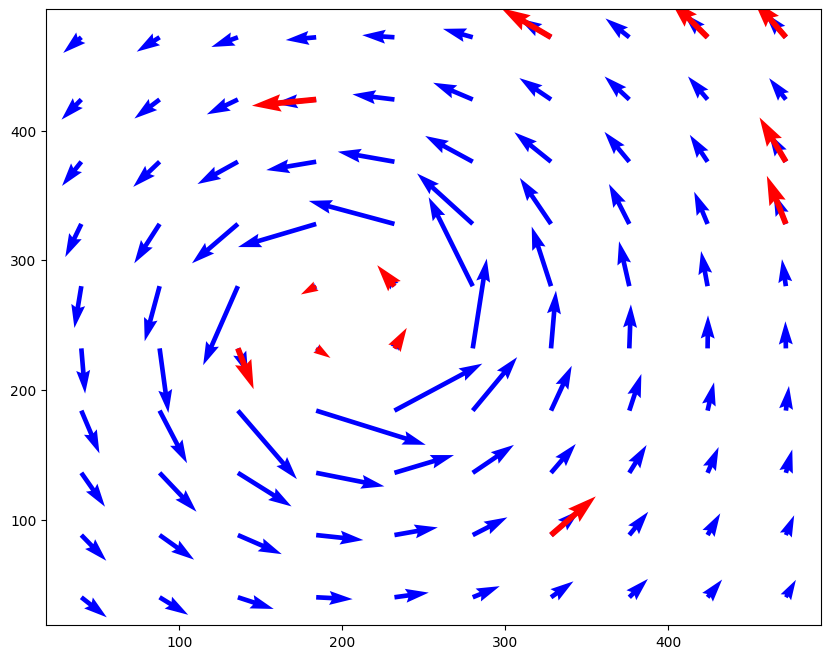

In [17]:
winsize = 32 # pixels
searchsize = 64  # pixels, search in image B
overlap = 16 # pixels
dt = 1.0 # sec
u0, v0, sig2noise = pyprocess.extended_search_area_piv( frame_a.astype(np.int32), frame_b.astype(np.int32), window_size=winsize, overlap=overlap, dt=dt, search_area_size=searchsize, sig2noise_method='peak2peak' )
x, y = pyprocess.get_coordinates( image_size=frame_a.shape,search_area_size=searchsize, overlap=overlap )
u, v, mask = validation.sig2noise_val( u0, v0, sig2noise, threshold = 1.1 )
u, v = filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)
# x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 96.52 )

plt.figure(figsize=(10,8))
plt.quiver(x,y,u,v,color='b')
plt.quiver(x[mask],y[mask],u[mask],v[mask],color='r')

# Simplest possible run using `openpiv.piv.simple_piv`

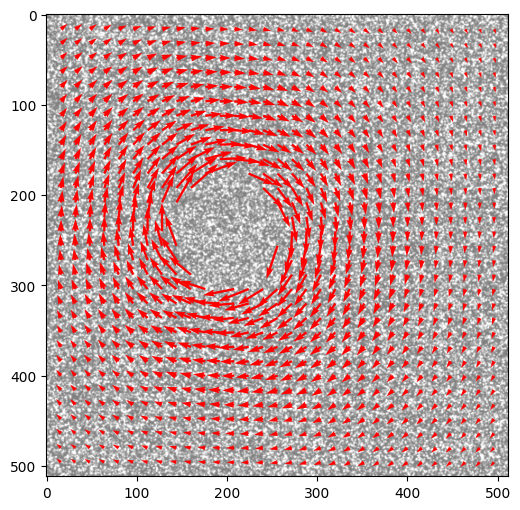

In [18]:
from openpiv import piv, tools

x,y,u,v,s2n = piv.simple_piv(frame_a, frame_b, plot=True)

# How to use IpyWidgets to get an interactive GUI
## Import ipywidgets 
read more about those on https://ipywidgets.readthedocs.io/en/stable/index.html

In [19]:
from ipywidgets import interact, interactive, fixed, interact_manual

In [20]:
def func(winsize,overlap,searchsize,s2n_method,s2n_threshold):
    if overlap >= winsize:
        overlap -= 1
        
    u, v, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), frame_b.astype(np.int32), window_size=winsize, overlap=overlap, dt=dt, search_area_size=searchsize, sig2noise_method=s2n_method )
    x, y = pyprocess.get_coordinates( image_size=frame_a.shape, search_area_size=searchsize, overlap=overlap )
    u, v, mask = validation.sig2noise_val( u, v, sig2noise, threshold = s2n_threshold )
    u, v = filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)
    plt.figure(figsize=(10,8))
    plt.quiver(x,y,u,v,color='b')
    plt.quiver(x[mask],y[mask],u[mask],v[mask],color='r');

## Press Run interact to get PIV output for the values in the list 

In [21]:
def run():
    interact_manual(func,winsize=[32,8,16,64,128],
                overlap=[16,8,32,64], 
                searchsize=[64,16,32,128,256],
                s2n_method=['peak2peak','peak2mean'],
                s2n_threshold=(1.0,1.5,.05));

In [22]:
run()

interactive(children=(Dropdown(description='winsize', options=(32, 8, 16, 64, 128), value=32), Dropdown(descri…

## Let's say you want this GIF motion from the excellent JPIV website 

In [23]:
from IPython.display import Image
Image(url='https://eguvep.github.io/jpiv/fig/bode.gif')

In [24]:
# read it:
import imageio
gif = imageio.get_reader('https://eguvep.github.io/jpiv/fig/bode.gif')

In [25]:
frames = []
for frame in gif:
    frames.append(frame)

In [26]:
# convert to gray scale
from skimage import img_as_uint
# frame_a = img_as_uint(gif[0])
# frame_b = img_as_uint(gif[1])

frame_a = frames[0][:,:,2]
frame_b = frames[1][:,:,2]

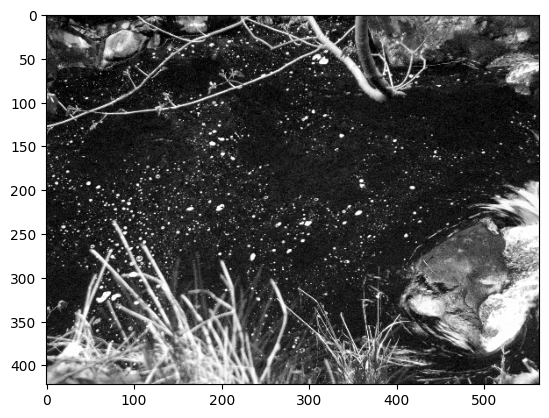

In [27]:
# see if this is what you want
plt.figure()
plt.imshow(frame_a,cmap=plt.cm.gray)

In [28]:
def run():
    interact_manual(func,winsize=[32,8,16,64,128],
                overlap=[16,8,32,64], 
                searchsize=[64,16,32,128,256],
                s2n_method=['peak2peak','peak2mean'],
                s2n_threshold=(1.0,1.5,.05));

In [29]:
run()

interactive(children=(Dropdown(description='winsize', options=(32, 8, 16, 64, 128), value=32), Dropdown(descri…